In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import floor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import sys

In [36]:
%matplotlib inline
mpl.matplotlib_fname()
mpl.rc_file_defaults()

In [37]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

def to_one_hot(category_array):
    ca = category_array # 1D array with values of the categories
    nr_categories = np.max(ca)+1
    nr_points = len(ca)
    one_hot = np.zeros((nr_points,nr_categories),dtype=int)
    one_hot[range(nr_points),ca] = 1
    return one_hot

def from_one_hot(one_hot_array):
    category_arr = np.nonzero(one_hot_array)[1]
    return category_arr

In [38]:
input_data = np.arange(0, 1000).reshape(1000,1)
#output_data = np.zeros((len(input_data),2),dtype=int)
#output_data[:500,0] = 1
#output_data[500:,1] = 1
output_data = np.zeros(len(input_data),dtype=int)
output_data[floor(len(input_data)/2):] = 1
output_one_hot = to_one_hot(output_data)
nr_params = output_onehot.shape[1]
nr_datapoints = input_data.shape[0]; nr_datapoints,nr_params

(1000, 2)

In [24]:
np.random.seed(1)
n_points = 1000
x = np.arange(0,n_points)
y = np.random.randn(n_points)*25
input_data = np.c_[(x,y)]

output_data = np.zeros(n_points,dtype=int)
output_data[input_data[:,0]+input_data[:,1]>500] = 1
output_one_hot = to_one_hot(output_data)
nr_datapoints, nr_params = input_data.shape
print(nr_datapoints,nr_params)
input_data += np.random.randn(n_points,2)*25

1000 2


In [11]:
data_pd = pd.read_csv("../data/credit_card_cleaned.csv")
data = data_pd.to_numpy()[::50,:]
output = data[:,-1]
input_data = data[:,:-1]
print(output.shape, input_data.shape)
output_one_hot = to_one_hot(output)

(387,) (387, 25)


In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_one_hot)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [40]:
Y_test.shape
X_train.shape

(750, 1)

In [62]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()
        
        # Accuracy score tracking
        self.accuracy_each_epoch_train = np.zeros(epochs)
        self.accuracy_each_epoch_test = np.zeros(epochs)
        

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        print('shape input',self.X_data.shape)
        print('shape w_h',self.hidden_weights.shape)
        print('shape b_h',self.hidden_bias.shape)
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = sigmoid(self.z_h)
        print('shape z_h',self.z_h.shape)
        print('shape a_h',self.a_h.shape)

        print('shape w_o',self.output_weights.shape)
        print('shape b_o',self.output_bias.shape)
        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias
        print('shape z_o',self.z_o.shape)
        print('shape a_o',sigmoid(self.z_o).shape)

        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
#        print('shape prob',self.probabilities.shape)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = sigmoid(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = (self.probabilities - self.Y_data)
        print('error output',error_output.shape)
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)
        print('error hidden',error_hidden.shape)
        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        print('grad_w_o shape',self.output_weights_gradient.shape)
        print('w_o shape',self.output_weights.shape)
        sys.exit()
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in tqdm(range(self.epochs)):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                #print(chosen_datapoints)
                #print(self.Y_data_full.shape)
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()
            
            self.accuracy_each_epoch_test[i] = self.accuracy_score(from_one_hot(Y_test),self.predict(X_test_scaled))
            self.accuracy_each_epoch_train[i] = self.accuracy_score(from_one_hot(self.Y_data_full),self.predict(self.X_data_full))
            #self.accuracy_each_epoch_train[i] = self.accuracy_score2(Y_train,self.predict(X_train_scaled))
            #self.accuracy_each_epoch_test[i] = self.accuracy_score2(Y_test,self.predict(X_test_scaled))
            
            
    def accuracy_score(self,Y_test, Y_pred):
        return np.sum(Y_test == Y_pred) / len(Y_test)
    
    def accuracy_score2(self,Y_test, Y_pred):
        return np.sum(np.argwhere(Y_test==1)[:,1] == Y_pred)/len(Y_test)

In [63]:
nn = NeuralNetwork( X_train_scaled,
                    Y_train,
                    n_hidden_neurons=4,
                    n_categories=2,
                    epochs=500,
                    batch_size=20,
                    eta=1e-5,
                    lmbd=0)
nn.train()

  0%|          | 0/500 [00:00<?, ?it/s]

shape input (20, 1)
shape w_h (1, 4)
shape b_h (4,)
shape z_h (20, 4)
shape a_h (20, 4)
shape w_o (4, 2)
shape b_o (2,)
shape z_o (20, 2)
shape a_o (20, 2)
error output (20, 2)
error hidden (20, 4)
grad_w_o shape (4, 2)
w_o shape (4, 2)


SystemExit: 

(250,)


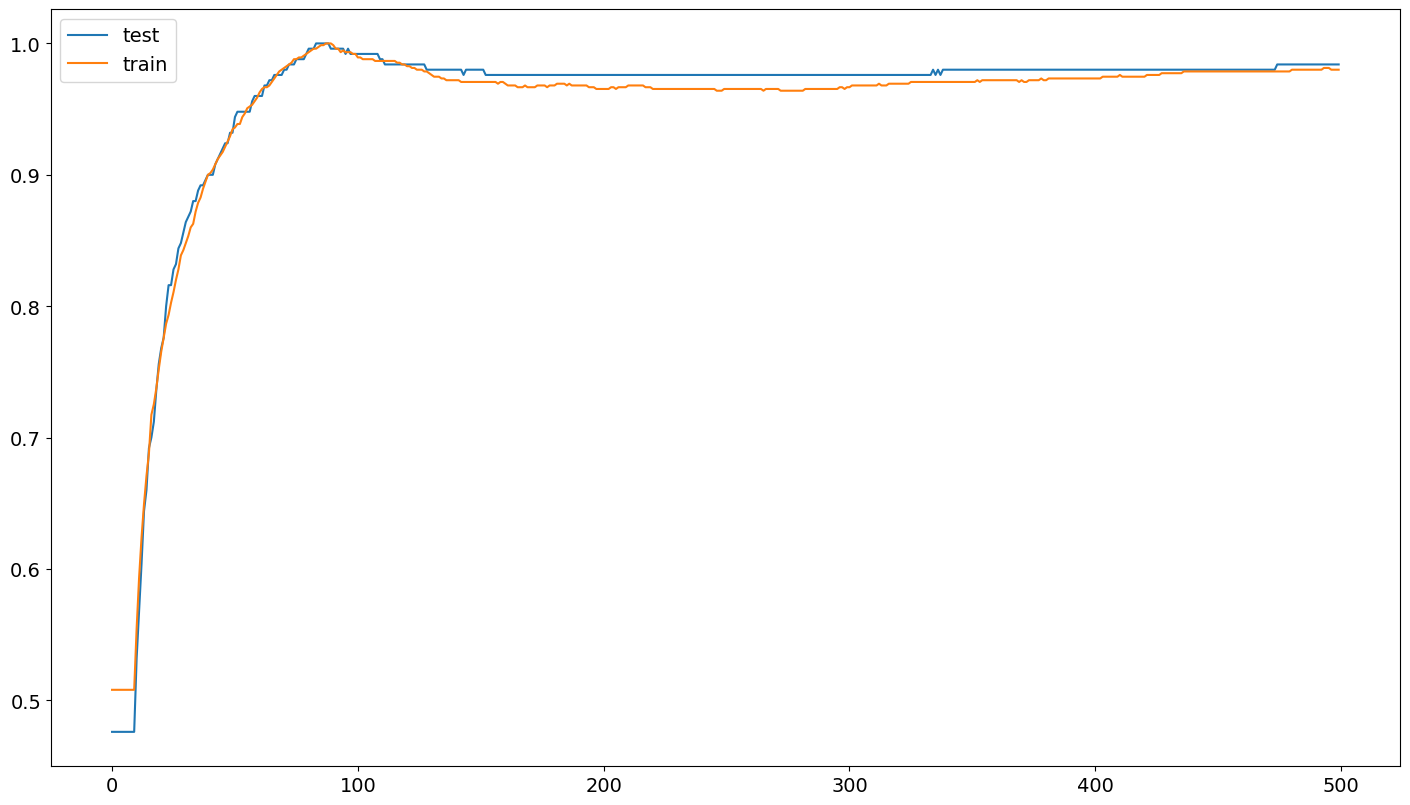

In [48]:
Y_pred = nn.predict(X_test_scaled)
print(Y_pred.shape)
#print(Y_pred)
#print(accuracy_score(from_one_hot(Y_test),Y_pred))
plt.figure()
plt.plot(np.arange(nn.epochs),nn.accuracy_each_epoch_test,label='test')
plt.plot(np.arange(nn.epochs),nn.accuracy_each_epoch_train,label='train')
plt.legend()

In [174]:
etas = np.logspace(-7,-1,10)
lmbds = np.logspace(-7,-3,3)
lmbds[-1] = 0.0
many_nns = np.zeros((len(etas),len(lmbds)),dtype=object)

for i,eta in enumerate(etas):
    for j,lmbd in enumerate(lmbds):
        nn = NeuralNetwork( X_train_scaled,Y_train,n_hidden_neurons=5,n_categories=2,epochs=1000,batch_size=50,
                    eta=eta,
                    lmbd=lmbd)
        nn.train()
        many_nns[i,j] = nn


100%|██████████| 1000/1000 [00:01<00:00, 949.45it/s]


0.38144329896907214
0.3711340206185567
0.6185567010309279
0.20618556701030927
0.30927835051546393
0.5051546391752577
0.2268041237113402
0.6185567010309279
0.5567010309278351
0.7525773195876289
0.7628865979381443
0.7938144329896907
0.7731958762886598
0.7938144329896907
0.7938144329896907
0.8041237113402062
0.8350515463917526
0.7628865979381443
0.8247422680412371
0.7835051546391752
0.7938144329896907
0.6907216494845361
0.7628865979381443
0.7835051546391752
0.7319587628865979
0.7525773195876289
0.7010309278350515
0.7525773195876289
0.6907216494845361
0.7010309278350515


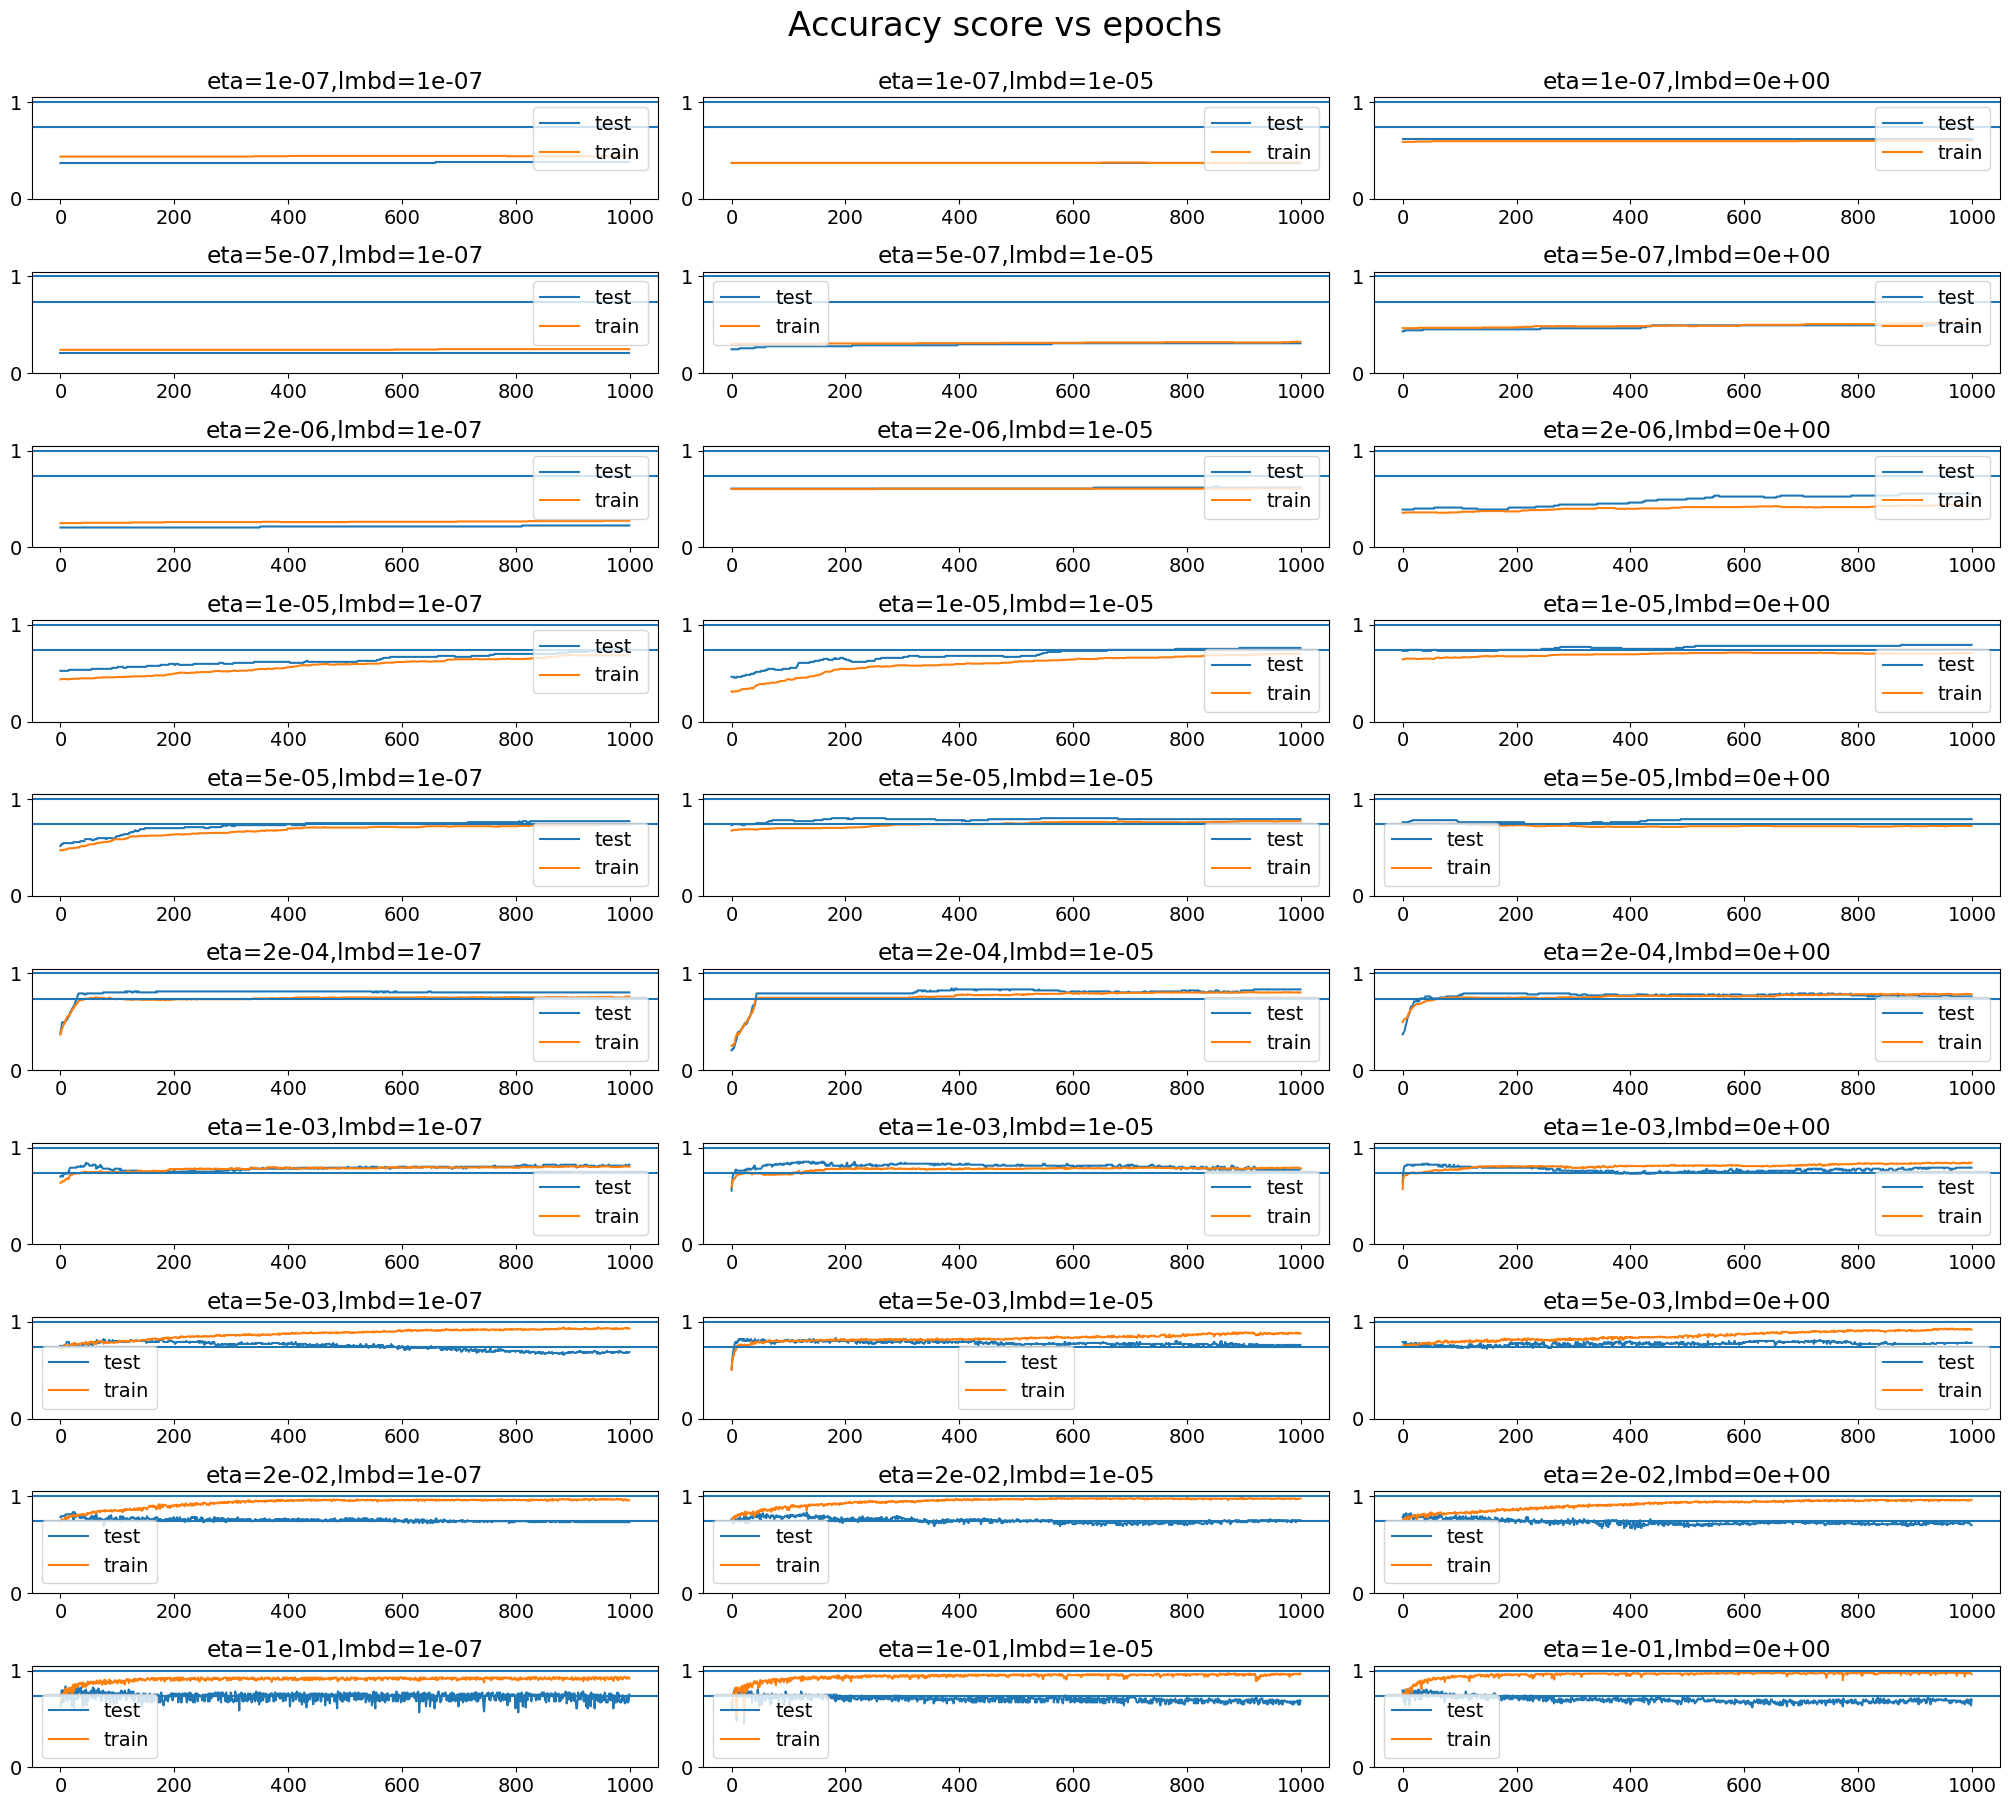

In [176]:
fig,ax = plt.subplots(len(etas),len(lmbds),figsize=(20,18))
#epochs_arr = np.arange(nn.epochs)
for i,eta in enumerate(etas):
    for j,lmbd in enumerate(lmbds):
        ax[i,j].plot(many_nns[i,j].accuracy_each_epoch_test,label='test')
        ax[i,j].plot(many_nns[i,j].accuracy_each_epoch_train,label='train')
        ax[i,j].legend()
        ax[i,j].set_title('eta={:.0e},lmbd={:.0e}'.format(eta,lmbd))
        ax[i,j].set_ylim(0,1.05)
        ax[i,j].axhline(1.0)
        ax[i,j].axhline(0.74)
        print(many_nns[i,j].accuracy_each_epoch_test[-1])
fig.suptitle('Accuracy score vs epochs')
plt.savefig('./../figs/testing_accuracy_eta_lambda.pdf')

In [154]:
clf = MLPClassifier(verbose=1,max_iter=1000)
clf.fit(X_train_scaled,Y_train)

Iteration 1, loss = 1.62233500
Iteration 2, loss = 1.57359206
Iteration 3, loss = 1.52687698
Iteration 4, loss = 1.48220696
Iteration 5, loss = 1.43959162
Iteration 6, loss = 1.39904677
Iteration 7, loss = 1.36052650
Iteration 8, loss = 1.32396160
Iteration 9, loss = 1.28936034
Iteration 10, loss = 1.25666755
Iteration 11, loss = 1.22587062
Iteration 12, loss = 1.19680962
Iteration 13, loss = 1.16949059
Iteration 14, loss = 1.14368654
Iteration 15, loss = 1.11935111
Iteration 16, loss = 1.09636326
Iteration 17, loss = 1.07464063
Iteration 18, loss = 1.05415656
Iteration 19, loss = 1.03484704
Iteration 20, loss = 1.01661217
Iteration 21, loss = 0.99944628
Iteration 22, loss = 0.98328441
Iteration 23, loss = 0.96802227
Iteration 24, loss = 0.95358018
Iteration 25, loss = 0.93989445
Iteration 26, loss = 0.92691842
Iteration 27, loss = 0.91460353
Iteration 28, loss = 0.90291909
Iteration 29, loss = 0.89181243
Iteration 30, loss = 0.88124843
Iteration 31, loss = 0.87117849
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=1, warm_start=False)

In [153]:
clf.score(X_test_scaled,Y_test)

0.7959183673469388

In [26]:
etas = np.logspace(-7,1,9)
many_nns_only_eta = np.zeros(len(etas),dtype=object)

for i,eta in enumerate(etas):
    nn = NeuralNetwork( X_train_scaled,Y_train,n_hidden_neurons=1,n_categories=2,epochs=500,batch_size=50,
                eta=eta,
                lmbd=0)
    nn.train()
    many_nns_only_eta[i] = nn


100%|██████████| 500/500 [00:01<00:00, 337.55it/s]


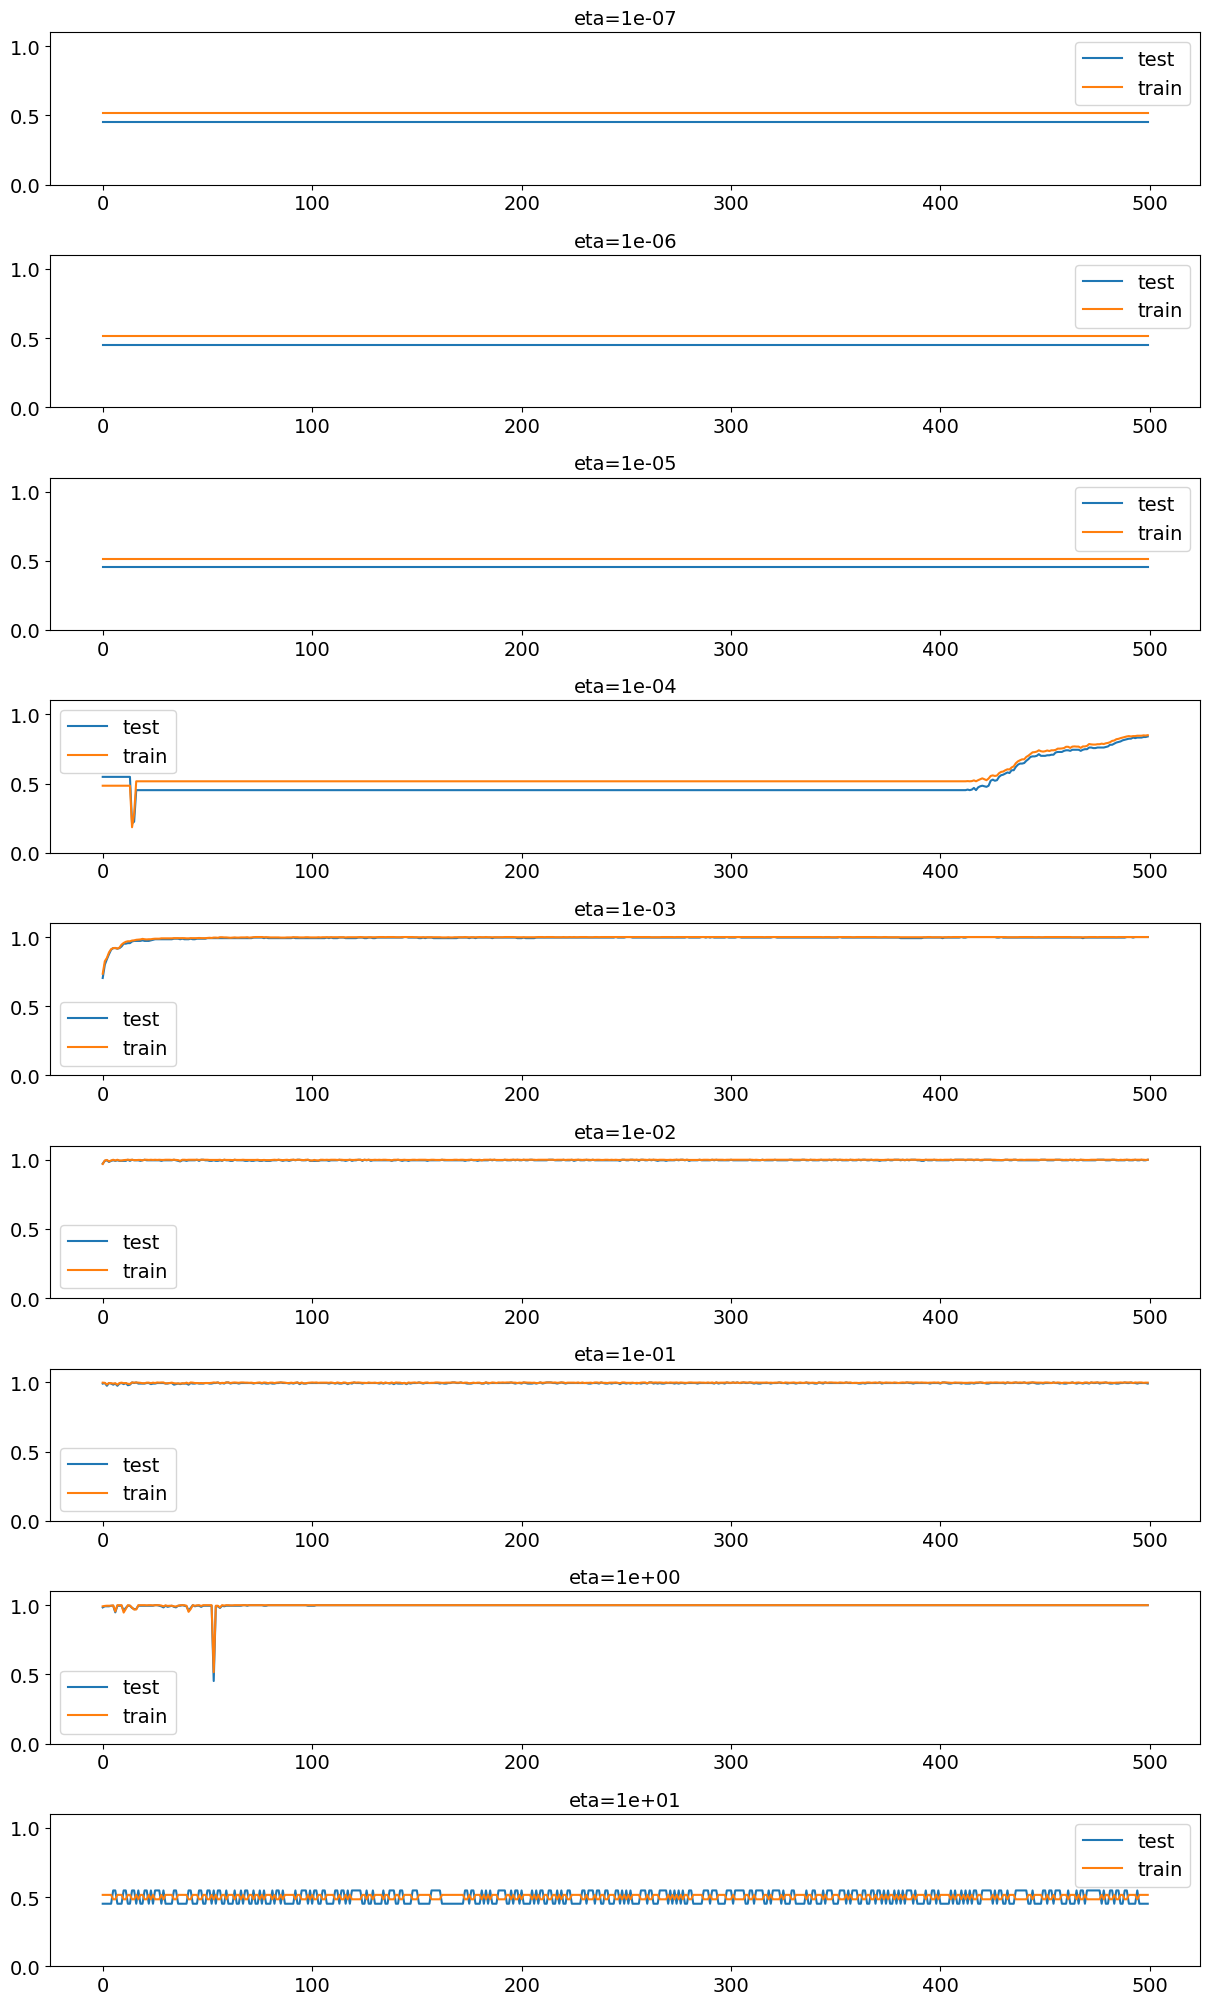

In [28]:
fig,ax = plt.subplots(len(etas),figsize=(12,20))
epochs_arr = np.arange(nn.epochs)
for i,eta in enumerate(etas):
    ax[i].plot(epochs_arr,many_nns_only_eta[i].accuracy_each_epoch_test,label='test')
    ax[i].plot(epochs_arr,many_nns_only_eta[i].accuracy_each_epoch_train,label='train')
    ax[i].legend()
    ax[i].set_title('eta={:.0e}'.format(eta,lmbd),fontsize=14)
    ax[i].set_ylim(0,1.1)

In [10]:
etas = np.logspace(-7,-1,9)
many_nns_only_eta_long = np.zeros(len(etas),dtype=object)

for i,eta in enumerate(etas):
    nn = NeuralNetwork( X_train_scaled,Y_train.reshape(-1,1),n_hidden_neurons=2,n_categories=2,epochs=1000,batch_size=4,
                eta=eta,
                lmbd=0)
    nn.train()
    many_nns_only_eta_long[i] = nn


 20%|█▉        | 196/1000 [00:05<00:23, 34.47it/s]/Users/jakobs/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/jakobs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/Users/jakobs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 1000/1000 [00:29<00:00, 33.64it/s]


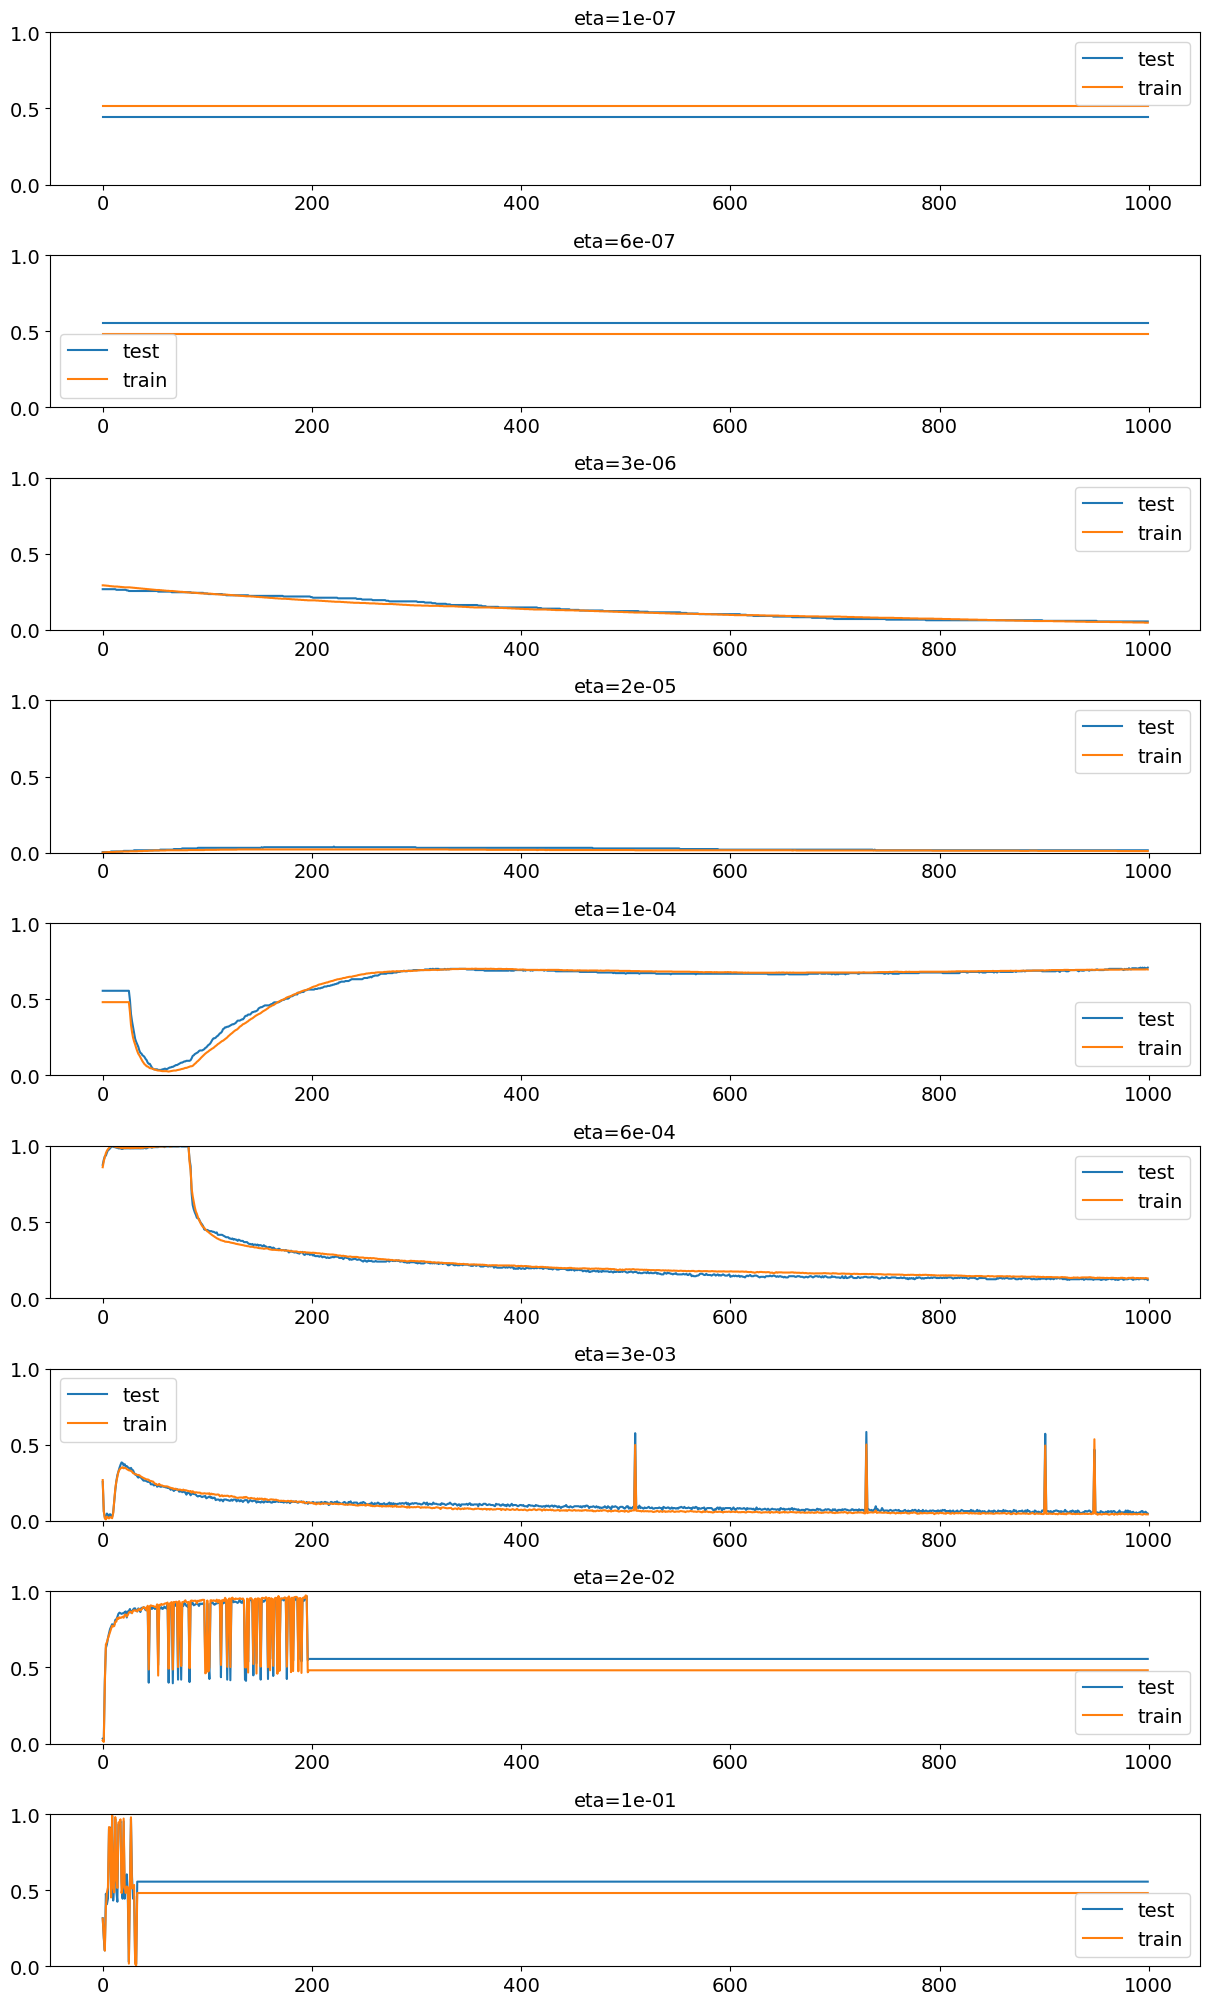

In [12]:
fig,ax = plt.subplots(len(etas),figsize=(12,20))
epochs_arr = np.arange(nn.epochs)
for i,eta in enumerate(etas):
    ax[i].plot(epochs_arr,many_nns_only_eta_long[i].accuracy_each_epoch_test,label='test')
    ax[i].plot(epochs_arr,many_nns_only_eta_long[i].accuracy_each_epoch_train,label='train')
    ax[i].legend()
    ax[i].set_title('eta={:.0e}'.format(eta),fontsize=14)
    ax[i].set_ylim(0,1)